In [ ]:
task = "Mistake_Identification"

In [ ]:
model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"

In [ ]:
model_to_be_trained = "llama-3.1-8B-Instruct"

In [ ]:
extra = '-training-subset'

In [ ]:
new_folder_name = f'{model_to_be_trained}-{task}{extra}'

In [ ]:
new_folder_name

### Connect to Drive

In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Connect to Wandb

In [ ]:
import wandb
WANDB_API_KEY="YOUR_WANDB_API_KEY"
wandb.login(key=WANDB_API_KEY)
wandb_project = new_folder_name
wandb.init(project=wandb_project)

### Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

<a name="Data"></a>

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split

alpaca_prompt = """### Instruction:
{}

### Input:
{}

### Response:
{}"""

dataset = load_dataset("json", data_files=f"/content/drive/~/Full_devset_with_llama_instruction.jsonl")

# Function to format prompts
EOS_TOKEN = tokenizer.eos_token  # Ensure tokenizer is defined before this

def formatting_prompts_func(example):
    text = alpaca_prompt.format(example["instruction"], example["input"], "Evaluation: "+example["output"]) + EOS_TOKEN
    return {"text": text, "output": example["output"]}

# Apply formatting
formatted_dataset = dataset.map(formatting_prompts_func)

# Convert to Pandas DataFrame
df = formatted_dataset["train"].to_pandas()

# Perform stratified train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["output"], random_state=42)

# Convert back to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# Create DatasetDict
split_dataset = DatasetDict({"train": train_dataset, "test": test_dataset})



### Dataset Analysis:

In [ ]:
# Print class distributions to verify stratification
print("Train Class Distribution:\n", train_dataset.to_pandas()["output"].value_counts())
print("\nTest Class Distribution:\n", test_dataset.to_pandas()["output"].value_counts())

Train Class Distribution:
 output
Yes               1545
No                 296
To some extent     139
Name: count, dtype: int64

Test Class Distribution:
 output
Yes               387
No                 74
To some extent     35
Name: count, dtype: int64


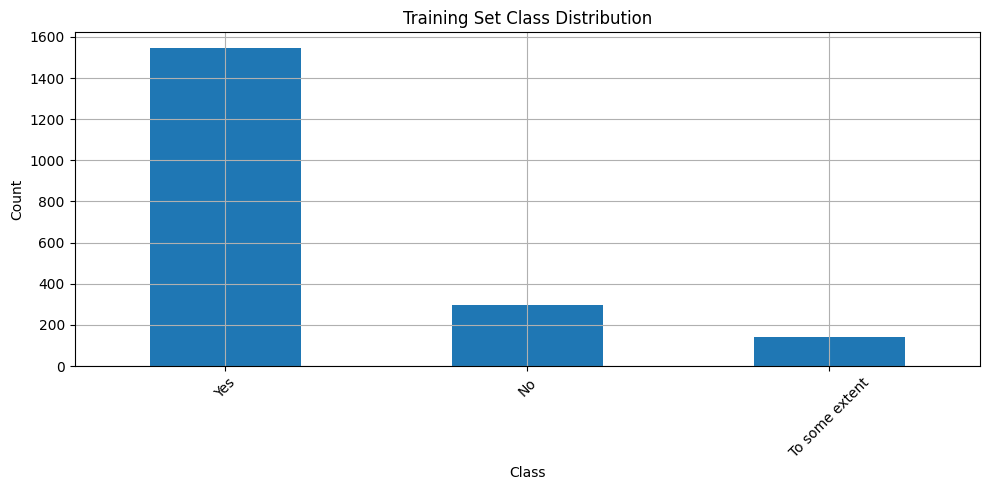

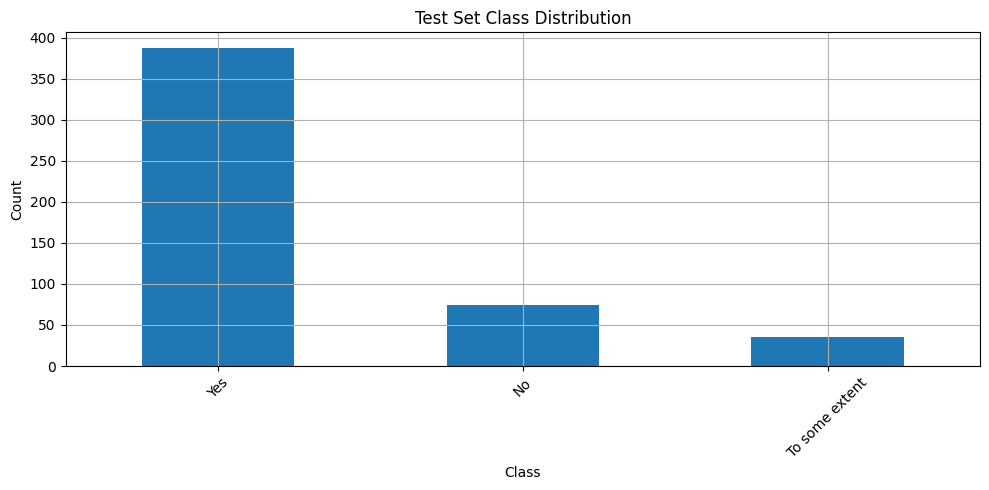

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(df, title):
    counts = df["output"].value_counts()
    plt.figure(figsize=(10, 5))
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_df, "Training Set Class Distribution")
plot_class_distribution(test_df, "Test Set Class Distribution")

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 60,
        num_train_epochs=3,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = ["wandb"], # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1980 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/496 [00:00<?, ? examples/s]

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
10.854 GB of memory reserved.


### Train:

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,980 | Num Epochs = 3 | Total steps = 369
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.031700
2,1.722800
3,1.831700
4,1.798100
5,1.653800
6,1.538200
7,1.401400
8,1.286500
9,1.149300
10,0.932900


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

10105.3589 seconds used for training.
168.42 minutes used for training.
Peak reserved memory = 10.854 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 73.631 %.
Peak reserved memory for training % of max memory = 0.0 %.


### Save Model:

In [ ]:
from huggingface_hub import login, HfApi, HfFolder
from transformers import AutoModel, AutoTokenizer

# 1. Login to Hugging Face
login(token="YOUR_HUGGING_FACE_TOKEN")  # Replace with your Hugging Face token

# 2. Save model & tokenizer
model.save_pretrained(new_folder_name, safe_serialization=True)
tokenizer.save_pretrained(new_folder_name)

# 3. Create repo if it doesn’t exist
repo_id = f"FDekmak/{new_folder_name}"  # Replace with your repo name
api = HfApi()
api.create_repo(repo_id=repo_id, private=True, exist_ok=True)

# 4. Push model to Hugging Face Hub
from huggingface_hub import upload_folder

upload_folder(
    folder_path=new_folder_name,  # Path to saved model
    repo_id=repo_id,
    commit_message="Uploading fine-tuned model"
)

print(f"Model successfully uploaded to: https://huggingface.co/{repo_id}")


### Load Model if needed:

In [ ]:
from huggingface_hub import login, HfApi, HfFolder
from unsloth import FastLanguageModel

# 1. Login to Hugging Face
login(token="YOUR_HUGGING_FACE_TOKEN")  # Replace with your Hugging Face token

# 3. Create repo if it doesn’t exist
repo_id = f"FDekmak/{new_folder_name}"  # Replace with your repo name

# 1. Load base model using Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,  # or whatever base you used
    max_seq_length=2048,
    load_in_4bit=True
)

# 2. Load your adapter (the one you pushed)
from peft import PeftModel

model = PeftModel.from_pretrained(model, repo_id)


<a name="Inference"></a>
### Inference


In [ ]:
inference_dataset = test_dataset
import time
start = time.time()

In [ ]:
# output folder

base_path = '/content/drive/~'  # Replace with your desired base path

new_folder_path = os.path.join(base_path, new_folder_name)

if not os.path.exists(new_folder_path):
  os.makedirs(new_folder_path)
  print(f"Folder '{new_folder_name}' created at '{new_folder_path}'")
else:
  print(f"Folder '{new_folder_name}' already exists at '{new_folder_path}'")


In [ ]:
import torch
import pandas as pd
import re
from sklearn.metrics import f1_score, classification_report

# Ensure the model is in inference mode
FastLanguageModel.for_inference(model)

# Store results
results = []

for example in inference_dataset:
    # Tokenize input
    inputs = tokenizer([example["text"].split("\nEvaluation")[0]], return_tensors="pt").to("cuda")

    # Generate response
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        use_cache=True,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
    )

    # Decode and extract response
    response_text = tokenizer.batch_decode(outputs)[0]
    extracted_text = response_text.split("### Response:", 1)[-1].strip()

    # Extract mistake identification decision using regex
    # match = re.search(r"Evaluation:\s*(Yes \(and the answer is correct\)|No|Yes \(but the answer is incorrect\))", extracted_text, re.IGNORECASE)
    match = re.search(r"Evaluation:\s*(Yes|No|To some extent)", extracted_text, re.IGNORECASE)
    model_prediction = match.group(1) if match else "Unknown"

    # Store results
    results.append({
        "Instruction": example['instruction'],
        "Input": example['input'],
        "Model Output": extracted_text,
        "Extracted Prediction": model_prediction,
        "Ground Truth": example['output'],
        "Match": model_prediction.lower() == example['output'].lower()
    })

# Convert results to DataFrame
df = pd.DataFrame(results)

# Compute accuracy
accuracy = df["Match"].mean() * 100

# Convert labels to categorical format for F1-score computation
label_mapping = {
    "Yes": 0,
    "No": 1,
    "To some extent": 2
}


# Save DataFrame to CSV
df.to_csv(f"{new_folder_path}/{task}_results.csv", index=False)

# Print evaluation results
print(f"Accuracy: {accuracy:.2f}%")

# Display sample of results
df.head()

Accuracy: 84.48%


,Instruction,Input,Model Output,Extracted Prediction,Ground Truth,Match
0,Evaluate the tutor's response based on whether...,"Tutor: Hi, could you please provide a step-by-...",Evaluation: Yes<|eot_id|>,Yes,No,False
1,Evaluate the tutor's response based on whether...,"Tutor: Hi, could you please provide a step-by-...",Evaluation: To some extent<|eot_id|>,To some extent,Yes,False
2,Evaluate the tutor's response based on whether...,"Tutor: Hi, could you please provide a step-by-...",Evaluation: Yes<|eot_id|>,Yes,Yes,True
3,Evaluate the tutor's response based on whether...,"Tutor: Hi, could you please provide a step-by-...",Evaluation: Yes<|eot_id|>,Yes,Yes,True
4,Evaluate the tutor's response based on whether...,Tutor: Please have a look at the steps on the ...,Evaluation: Yes<|eot_id|>,Yes,Yes,True


In [ ]:
time.time() - start

450.2686941623688

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Ensure both columns are strings and normalize case
df["Extracted Prediction"] = df["Extracted Prediction"].astype(str).str.lower().apply(lambda x: x.strip().strip("."))
df["Ground Truth"] = df["Ground Truth"].astype(str).str.lower().apply(lambda x: x.strip().strip("."))

# Compute classification report
report = classification_report(df["Ground Truth"], df["Extracted Prediction"], digits=4, zero_division=0)

# Print classification report
print(report)


                precision    recall  f1-score   support

            no     0.6795    0.7162    0.6974        74
to some extent     0.1250    0.0286    0.0465        35
       unknown     0.0000    0.0000    0.0000         0
           yes     0.8924    0.9432    0.9171       387

      accuracy                         0.8448       496
     macro avg     0.4242    0.4220    0.4152       496
  weighted avg     0.8065    0.8448    0.8229       496

